In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt

sns.set_theme(style="ticks", palette="pastel")
sns.set(font='serif')
%matplotlib inline

### Are the indicators distinct from one another?

We want indicators that are not all measuring the same behaviours. To find out which indicators are measuring the same behaviour, and which are distinct, we conduct Pearson correlation tests. Indicators which are highly correlated are characterising the same behaviour. Indicators which are not correlated, are distinct from one another.

In [2]:
tags = ["experiment","dimension","population_size","total_iterations","function","metaheuristic","control_parameters","run"]
diversity = ["DRoC_A","DRoC_B","ERT_Diversity","Critical_Diversity"]
fitness = ["FRoC_A","FRoC_B","ERT_Fitness","Critical_Fitness"]
separation = ["SRoC_A","SRoC_B","ERT_Separation","Critical_Separation"]
mobility = ["MRoC_A","MRoC_B","ERT_Mobility","Critical_Mobility"]
STN = ["ntotal","nbest","nshared","best_strength"]
IN = ["MID","MGC","SNID"]
others = ["EXPLORE","INFEASIBLE"]

indicators = diversity + fitness + separation + mobility + STN + IN + others
columns = tags + indicators
data = pd.read_csv("../../Results/characteristicTest/results.csv", names=columns)

In [3]:
metaheuristics = list(np.unique(data['metaheuristic']))
metaheuristics

['GBestPSO',
 'GreedyPSO',
 'Random20PSO',
 'RandomPSO',
 'RingPSO',
 'VonNeumannPSO']

In [4]:
functions = list(np.unique(data['function']))
functions

['AttractiveSector',
 'Brown',
 'Discus',
 'Ellipsoidal',
 'Elliptic',
 'Exponential',
 'GeneralizedDropWave',
 'GeneralizedEggCrate',
 'GeneralizedPrice2',
 'Mishra1',
 'NeedleEye',
 'Pinter',
 'Qing',
 'Rosenbrock',
 'SchwafferN7',
 'Schwefel_1.2',
 'Step3Function',
 'Weierstrass']

In [5]:
function_pretty = {
    'AttractiveSector': "Attractive Sector",
    'Brown': "Brown",
    'Discus': "Discus",
    'Ellipsoidal': "Ellipsoidal",
    'Elliptic': "Elliptic",
    'Exponential': "Exponential",
    'GeneralizedDropWave': "Drop Wave",
    'GeneralizedEggCrate': "Egg Crate",
    'GeneralizedPrice2': "Price 2",
    'Mishra1': "Mishra 1",
    'NeedleEye': "Needle Eye",
    'Pinter': "Pinter",
    'Qing': "Qing",
    'Rosenbrock': "Rosenbrock",
    'SchwafferN7': "Schwaffer 7",
    'Schwefel_1.2': "Schwefel $1.2$",
    'Step3Function': "Step 3",
    'Weierstrass': "Weierstrass"
}
indicator_pretty = {
    "DRoC_A": "DRoC Type A",
    "DRoC_B": "DRoC Type B",
    "ERT_Diversity": "ERT Diversity",
    "Critical_Diversity": "Critical Diversity",
    "FRoC_A": "FRoC Type A",
    "FRoC_B": "FRoC Type B",
    "ERT_Fitness": "ERT Fitness",
    "Critical_Fitness": "Critical Fitness",
    "SRoC_A": "SRoC Type A",
    "SRoC_B": "SRoC Type B",
    "ERT_Separation": "ERT Separation",
    "Critical_Separation": "Critical Separation",
    "MRoC_A": "MRoC Type A",
    "MRoC_B": "MRoC Type B",
    "ERT_Mobility": "ERT Mobility",
    "Critical_Mobility": "Critical Mobility",
    "ntotal": "ntotal",
    "nshared": "nshared",
    "MID": "Mean ID",
    "MGC": "Mean GC",
    "SNID": "SNID",
    "EXPLORE": "EXPLORE%",
    "INFEASIBLE": "INFEASIBLE%"
}
metaheuristics_short = {
    'GBestPSO': "sPSO",
    'GreedyPSO': "gPSO",
    'Random20PSO': "20PSO",
    'RandomPSO': "iPSO",
    'RingPSO': "rPSO",
    'VonNeumannPSO': "vnPSO"
}

# Data preparation

We already know from our previous analysis that nbest and best-strength have very little variation for a single experiment. This is going to cause problems if we want to calculate the correlation between these indicators for a given experiment, and any other indicator. You cannot calculate the correlation when either of the sets of data has only one distinct value. We also know from our KS test results that there is little variation between different experiments for those indicators too. For this reason, and the issues they bring regarding the calculation of correlations, we will exclude these two indicators from this test.

In [6]:
data = data.dropna(inplace=False)
df = data[["function", "metaheuristic"] + indicators]
df = df.drop(columns=['nbest', 'best_strength'], inplace=False)
indicators.remove('nbest')
indicators.remove('best_strength')

We calculate the Pearson correlation coefficient between every indicator for each unique metaheuristic and function.
. Given the quantity of data returned, we aggregate our results by displaying the highest correlation found between indicators, the average correlation found between indicators, and the lowest correlation found between indicators.

In [16]:
table_df = pd.DataFrame(columns=["Indicator","Metaheuristic","Function"] + indicators)

zero_matrix = np.zeros((len(indicators), len(indicators)))
ones_matrix = zero_matrix + 1

mean_df = pd.DataFrame(zero_matrix, columns=indicators, index=indicators)
count_df = pd.DataFrame(zero_matrix, columns=indicators, index=indicators)
min_df = pd.DataFrame(ones_matrix, columns=indicators, index=indicators)
max_df = pd.DataFrame(zero_matrix, columns=indicators, index=indicators)
max_set = {}
for function in functions:
    function_df = df[df["function"] == function]
    for metaheuristic in metaheuristics:
        correlation_matrix = function_df[function_df["metaheuristic"] == metaheuristic][indicators].corr(method='pearson')
        for indicator in indicators:
            table_df.loc[len(table_df.index)] = [indicator, metaheuristic, function] + list(correlation_matrix[indicator])
        count_df = count_df.mask(cond=correlation_matrix.notna(), other=count_df + 1)
        mean_df = mean_df.mask(cond=correlation_matrix.notna(), other=mean_df + abs(correlation_matrix))
        min_df = min_df.mask(cond=abs(correlation_matrix) < abs(min_df), other=correlation_matrix)
        max_mask = abs(correlation_matrix) > abs(max_df)
        if max_mask.any().any():
            index_pairs = max_mask.stack()[max_mask.stack()].index
            for index_pair in index_pairs:
                max_set[f"{index_pair[0]}, {index_pair[1]}"] = [function, metaheuristic]
        max_df = max_df.mask(cond=max_mask, other=correlation_matrix)
mean_df = mean_df / count_df

In [8]:
max_function = dict(zip(functions, [0] * len(functions)))
max_metaheuristic = dict(zip(metaheuristics, [0] * len(metaheuristics)))
for k, v in max_set.items():
    f, m = v
    max_function[f] += 1.0 / 529.0
    max_metaheuristic[m] += 1.0 / 529.0

In [9]:
dict(sorted(max_function.items(), key=lambda item: item[1]))

{'Pinter': 0.01512287334593573,
 'Qing': 0.018903591682419663,
 'SchwafferN7': 0.030245746691871463,
 'Schwefel_1.2': 0.030245746691871463,
 'Rosenbrock': 0.03402646502835539,
 'Step3Function': 0.03402646502835539,
 'Weierstrass': 0.03780718336483932,
 'Mishra1': 0.04536862003780717,
 'Elliptic': 0.0491493383742911,
 'Ellipsoidal': 0.05671077504725895,
 'Exponential': 0.05671077504725895,
 'GeneralizedDropWave': 0.05671077504725895,
 'Discus': 0.06049149338374288,
 'Brown': 0.06805293005671074,
 'GeneralizedEggCrate': 0.09073724007561439,
 'AttractiveSector': 0.09262759924385636,
 'GeneralizedPrice2': 0.10586011342155015,
 'NeedleEye': 0.11720226843100197}

In [10]:
dict(sorted(max_metaheuristic.items(), key=lambda item: item[1]))

{'RingPSO': 0.12476370510396985,
 'Random20PSO': 0.14366729678638943,
 'RandomPSO': 0.15500945179584116,
 'VonNeumannPSO': 0.15879017013232508,
 'GreedyPSO': 0.1965973534971642,
 'GBestPSO': 0.22117202268430963}

In [11]:
table_df.head()

,Indicator,Metaheuristic,Function,DRoC_A,DRoC_B,ERT_Diversity,Critical_Diversity,FRoC_A,FRoC_B,ERT_Fitness,...,MRoC_B,ERT_Mobility,Critical_Mobility,ntotal,nshared,MID,MGC,SNID,EXPLORE,INFEASIBLE
0,DRoC_A,GBestPSO,AttractiveSector,1.000000,0.632183,0.885377,-0.645687,-0.080954,-0.245017,-0.082092,...,-0.274027,-0.030533,0.249532,0.401062,0.395185,0.189533,-0.189533,0.084301,0.345590,0.169644
1,DRoC_B,GBestPSO,AttractiveSector,0.632183,1.000000,0.621194,-0.999732,-0.040958,-0.329429,-0.125423,...,-0.374627,0.084319,0.378609,0.317567,-0.036265,0.223867,-0.223867,0.172262,0.065533,0.108266
2,ERT_Diversity,GBestPSO,AttractiveSector,0.885377,0.621194,1.000000,-0.633261,-0.000893,-0.294880,0.058930,...,-0.182991,0.176440,0.156056,0.589766,0.363670,-0.005115,0.005115,0.212692,0.681723,0.167980
3,Critical_Diversity,GBestPSO,AttractiveSector,-0.645687,-0.999732,-0.633261,1.000000,0.042160,0.331359,0.123513,...,0.372759,-0.086319,-0.376204,-0.324439,0.026075,-0.224713,0.224713,-0.173123,-0.076587,-0.108247
4,FRoC_A,GBestPSO,AttractiveSector,-0.080954,-0.040958,-0.000893,0.042160,1.000000,0.428365,0.812165,...,0.357226,0.502754,-0.344861,0.003023,0.103250,0.162769,-0.162769,-0.008027,0.081386,0.457733


## Plots

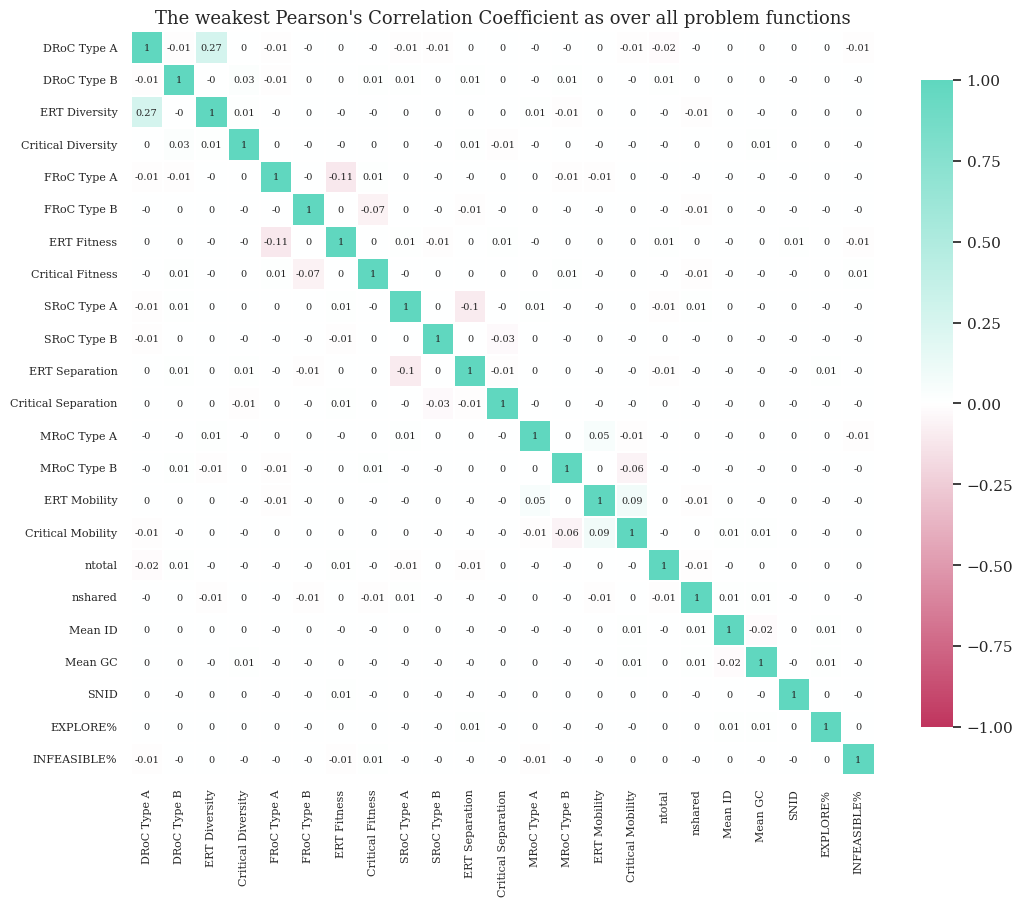

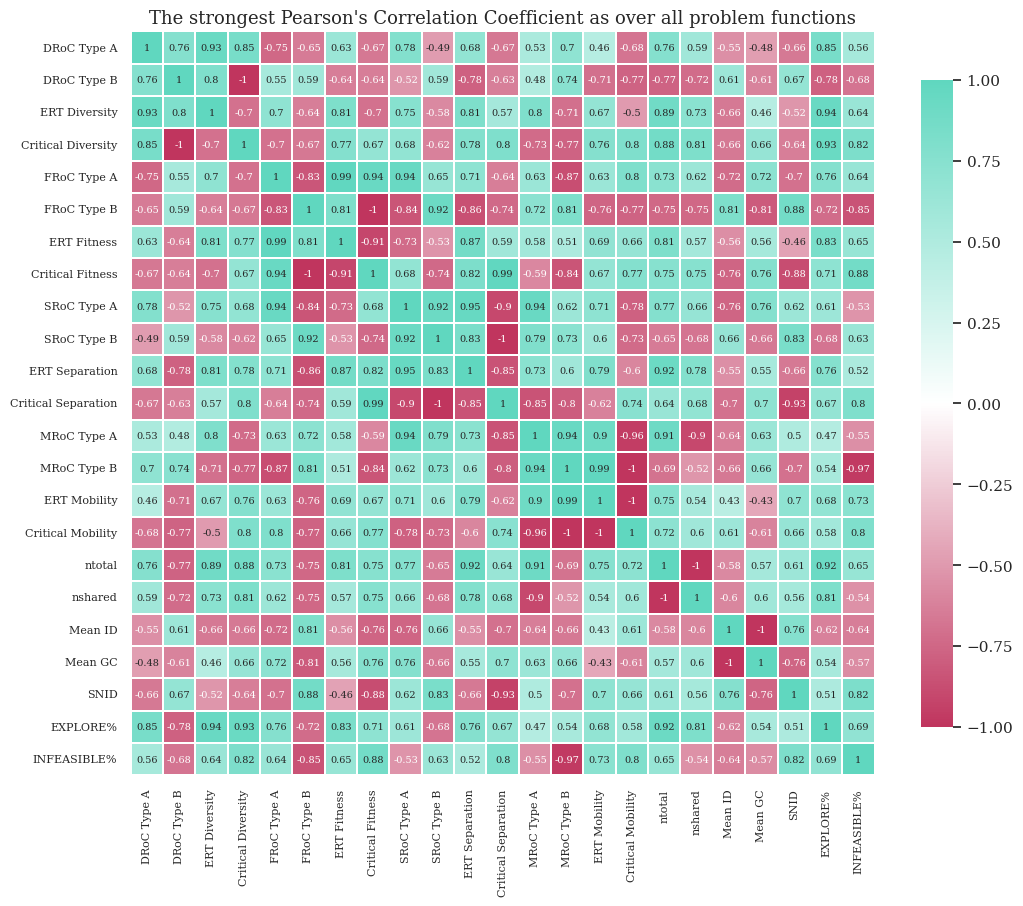

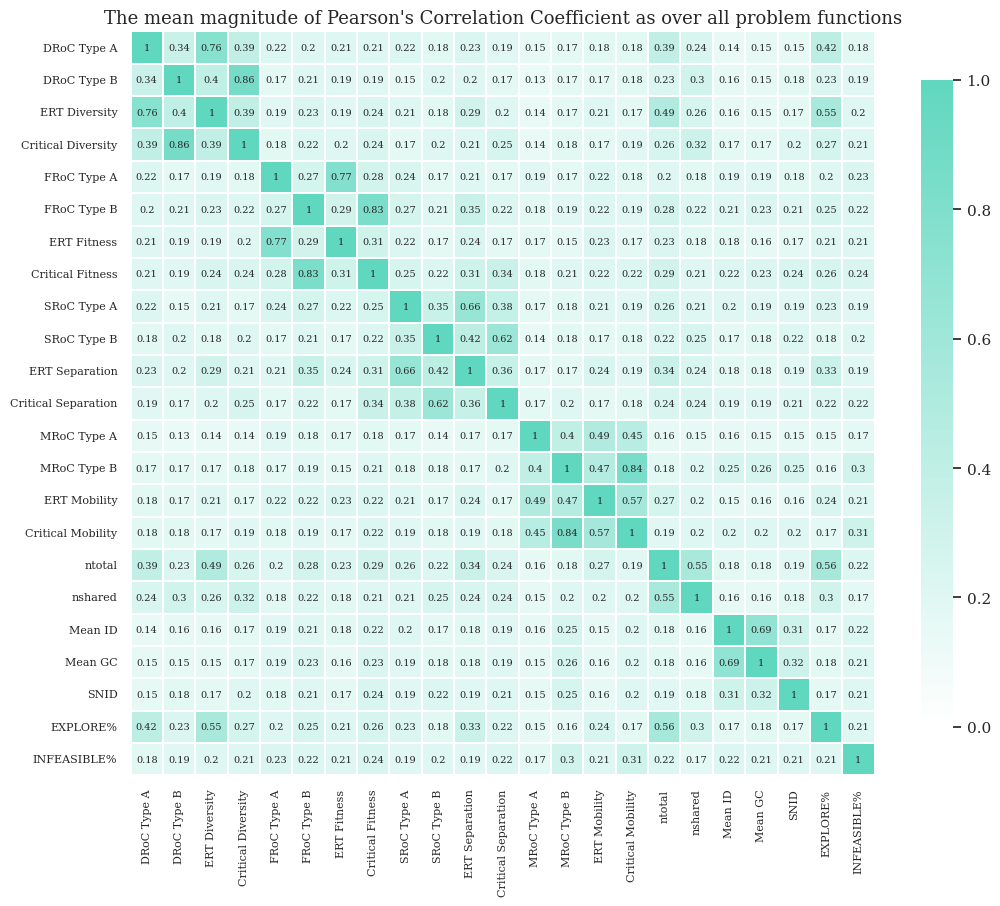

In [38]:
turquoise = "#60D7BF"
white = "#FFFFFF"
fuchsia = "#C0355E"
cmap1 = LinearSegmentedColormap.from_list("custom_gradient", [fuchsia, white, turquoise])
cmap2 = LinearSegmentedColormap.from_list("custom_gradient", [white, turquoise])
title_map = {
    id(min_df): "The weakest",
    id(max_df): "The strongest",
    id(mean_df): "The mean magnitude of"   
}
figure_type_map = {
    id(min_df): "weakest_correlation",
    id(max_df): "strongest_correlation",
    id(mean_df): "average_correlation" 
}

for dataset in [min_df, max_df, mean_df]:
    if dataset is mean_df:
        vmin, cmap = 0, cmap2
    else:
        vmin, cmap = -1, cmap1
    plt.figure(figsize=(12,12))
    dataset.columns = [indicator_pretty[x] for x in dataset.columns]
    dataset.index = [indicator_pretty[x] for x in dataset.index]
    g=sns.heatmap(dataset.round(2), vmin=vmin, vmax=1, cmap=cmap,
                  square=True, linewidths=0.1, cbar=True, cbar_kws={'shrink': 0.7},
                  annot=True, annot_kws={"fontsize":7}, fmt='.2g',
                  xticklabels=1, yticklabels=1) 

    g.set_xticklabels(g.get_xticklabels(), fontsize = 8)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
    plt.title(f"{title_map[id(dataset)]} Pearson's Correlation Coefficient as over all problem functions", fontsize=13, wrap=True)
    if not os.path.exists(f"../../plots/IndicatorDistinct/Pearson/"):
        os.makedirs(f"../../plots/IndicatorDistinct/Pearson/")
    plt.savefig(f"../../plots/IndicatorDistinct/Pearson/{figure_type_map[id(dataset)]}.pdf", bbox_inches='tight', dpi=600)
    plt.show()
plt.close('all')

## Table

In [9]:
def sort_col(series: pd.Series) -> pd.Series:
    try:
        return series.apply(lambda x: indicators.index(x))
    except ValueError:
        try:
            return series.apply(lambda x: list(function_pretty.values()).index(x))
        except ValueError:
            return series.apply(lambda x: list(metaheuristics_short.values()).index(x))

table_df['Function'] = table_df['Function'].apply(lambda x: function_pretty[x])
table_df['Metaheuristic'] = table_df['Metaheuristic'].apply(lambda x: metaheuristics_short[x])
indexed_table = table_df.sort_values(by=["Indicator", "Function", "Metaheuristic"], key=sort_col)
indexed_table.set_index(keys=["Indicator", "Function", "Metaheuristic"], inplace=True)
indexed_table.head(10)

DRoC_A    DRoC_B  ERT_Diversity  \
Indicator Function          Metaheuristic                                    
DRoC_A    Attractive Sector sPSO              1.0  0.632183       0.885377   
                            gPSO              1.0  0.529070       0.555764   
                            20PSO             1.0  0.530579       0.792377   
                            iPSO              1.0 -0.356502      -0.825625   
                            rPSO              1.0  0.490354       0.933155   
                            vnPSO             1.0  0.060742       0.822437   
          Brown             sPSO              1.0  0.272213       0.856279   
                            gPSO              1.0  0.595168       0.662732   
                            20PSO             1.0  0.366874       0.848610   
                            iPSO              1.0  0.447742      -0.568152   

                                           Critical_Diversity    FRoC_A  \
Indicator Function          Metaheuristic                                 
DRoC_A    Attractive Sector sPSO                    -0.645687 -0.080954   
                            gPSO                    -0.546919  0.175440   
                            20PSO                   -0.558676  0.047876   
                            iPSO                     0.472353 -0.407455   
                            rPSO                    -0.529287 -0.184525   
                            vnPSO                   -0.123911  0.067442   
          Brown             sPSO                    -0.301303  0.089778   
                            gPSO                    -0.624461  0.167492   
                            20PSO                   -0.420303 -0.283177   
                            iPSO                    -0.414650 -0.183983   

                                             FRoC_B  ERT_Fitness  \
Indicator Function          Metaheuristic                          
DRoC_A    Attractive Sector sPSO          -0.245017    -0.082092   
                            gPSO           0.232996     0.140356   
                            20PSO         -0.316911     0.155450   
                            iPSO          -0.258646     0.106470   
                            rPSO          -0.437703    -0.329031   
                            vnPSO         -0.371298    -0.010550   
          Brown             sPSO           0.052497     0.153429   
                            gPSO           0.165143     0.174458   
                            20PSO         -0.172211    -0.299204   
                            iPSO           0.526341    -0.258446   

                                           Critical_Fitness    SRoC_A  \
Indicator Function          Metaheuristic                               
DRoC_A    Attractive Sector sPSO                   0.244982  0.252595   
                            gPSO                   0.002349 -0.225509   
                            20PSO                  0.319124  0.130589   
                            iPSO                   0.354635 -0.289685   
                            rPSO                   0.436479 -0.037693   
                            vnPSO                  0.368952  0.209058   
          Brown             sPSO                  -0.052371 -0.147131   
                            gPSO                  -0.568756 -0.118810   
                            20PSO                  0.174003  0.156564   
                            iPSO                  -0.402676 -0.574071   

                                             SRoC_B  ...    MRoC_B  \
Indicator Function          Metaheuristic            ...             
DRoC_A    Attractive Sector sPSO          -0.222862  ... -0.274027   
                            gPSO           0.220479  ...  0.430101   
                            20PSO         -0.478256  ... -0.068484   
                            iPSO          -0.238948  ... -0.065468   
                            rPSO          -0.459267  ... -0.085838   
                     

In [10]:
for i in range(len(indicators)):
    indicator = indicators[i]
    print(indexed_table.loc[indicator].round(3).to_latex(label=f"tab:RQ2", longtable=True, float_format='%.3g', escape=False, na_rep='N/A', caption=f"The Pearson correlation coefficient of {indicator} and every other indicator, for each metaheuristic and problem function."))

\begin{longtable}{llrrrrrrrrrrrrrrrrrrrrrrr}
\caption{The Pearson correlation coefficient of DRoC_A and every other indicator, for each metaheuristic and problem function.} \label{tab:RQ2} \\
\toprule
 &  & DRoC_A & DRoC_B & ERT_Diversity & Critical_Diversity & FRoC_A & FRoC_B & ERT_Fitness & Critical_Fitness & SRoC_A & SRoC_B & ERT_Separation & Critical_Separation & MRoC_A & MRoC_B & ERT_Mobility & Critical_Mobility & ntotal & nshared & MID & MGC & SNID & EXPLORE & INFEASIBLE \\
Function & Metaheuristic &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\endfirsthead
\caption[]{The Pearson correlation coefficient of DRoC_A and every other indicator, for each metaheuristic and problem function.} \\
\toprule
 &  & DRoC_A & DRoC_B & ERT_Diversity & Critical_Diversity & FRoC_A & FRoC_B & ERT_Fitness & Critical_Fitness & SRoC_A & SRoC_B & ERT_Separation & Critical_Separation & MRoC_A & MRoC_B & ERT_Mobility & Critical_Mobility & ntotal & nshared & MID & MGC & 

In [24]:
max_df_set = {}
for column in max_df.columns:
    for row in max_df.index:
        max_df_set[f"{column}_{row}"] = max_df[column][row]

In [31]:
small = {k:v for k,v in max_df_set.items() if (abs(v) <= 0.5)}
dict(sorted(small.items(), key=lambda item: abs(item[1])))

{'ERT_Mobility_MID': np.float64(0.4295187553226831),
 'MID_ERT_Mobility': np.float64(0.4295187553226831),
 'ERT_Mobility_MGC': np.float64(-0.42951875532268374),
 'MGC_ERT_Mobility': np.float64(-0.42951875532268374),
 'ERT_Fitness_SNID': np.float64(-0.45687260238364774),
 'SNID_ERT_Fitness': np.float64(-0.45687260238364774),
 'ERT_Diversity_MGC': np.float64(0.45750860968091145),
 'MGC_ERT_Diversity': np.float64(0.45750860968091145),
 'DRoC_A_ERT_Mobility': np.float64(0.4609789411785092),
 'ERT_Mobility_DRoC_A': np.float64(0.4609789411785092),
 'MRoC_A_EXPLORE': np.float64(0.47453174995802),
 'EXPLORE_MRoC_A': np.float64(0.47453174995802),
 'DRoC_A_MGC': np.float64(-0.47826654355623477),
 'MGC_DRoC_A': np.float64(-0.47826654355623477),
 'DRoC_B_MRoC_A': np.float64(0.4828028536575864),
 'MRoC_A_DRoC_B': np.float64(0.4828028536575864),
 'DRoC_A_SRoC_B': np.float64(-0.4882541790254819),
 'SRoC_B_DRoC_A': np.float64(-0.4882541790254819),
 'ERT_Diversity_Critical_Mobility': np.float64(-0.4991

In [33]:
large = {k:v for k,v in max_df_set.items() if (v >= 0.99)}
dict(sorted(large.items(), key=lambda item: abs(item[1])))

{'FRoC_A_ERT_Fitness': np.float64(0.9944628855803789),
 'ERT_Fitness_FRoC_A': np.float64(0.9944628855803789),
 'DRoC_A_DRoC_A': np.float64(1.0),
 'DRoC_B_DRoC_B': np.float64(1.0),
 'ERT_Diversity_ERT_Diversity': np.float64(1.0),
 'Critical_Diversity_Critical_Diversity': np.float64(1.0),
 'FRoC_A_FRoC_A': np.float64(1.0),
 'FRoC_B_FRoC_B': np.float64(1.0),
 'ERT_Fitness_ERT_Fitness': np.float64(1.0),
 'Critical_Fitness_Critical_Fitness': np.float64(1.0),
 'SRoC_A_SRoC_A': np.float64(1.0),
 'SRoC_B_SRoC_B': np.float64(1.0),
 'ERT_Separation_ERT_Separation': np.float64(1.0),
 'Critical_Separation_Critical_Separation': np.float64(1.0),
 'MRoC_A_MRoC_A': np.float64(1.0),
 'MRoC_B_MRoC_B': np.float64(1.0),
 'ERT_Mobility_ERT_Mobility': np.float64(1.0),
 'Critical_Mobility_Critical_Mobility': np.float64(1.0),
 'ntotal_ntotal': np.float64(1.0),
 'nshared_nshared': np.float64(1.0),
 'MID_MID': np.float64(1.0),
 'MGC_MGC': np.float64(1.0),
 'SNID_SNID': np.float64(1.0),
 'EXPLORE_EXPLORE': np.fl

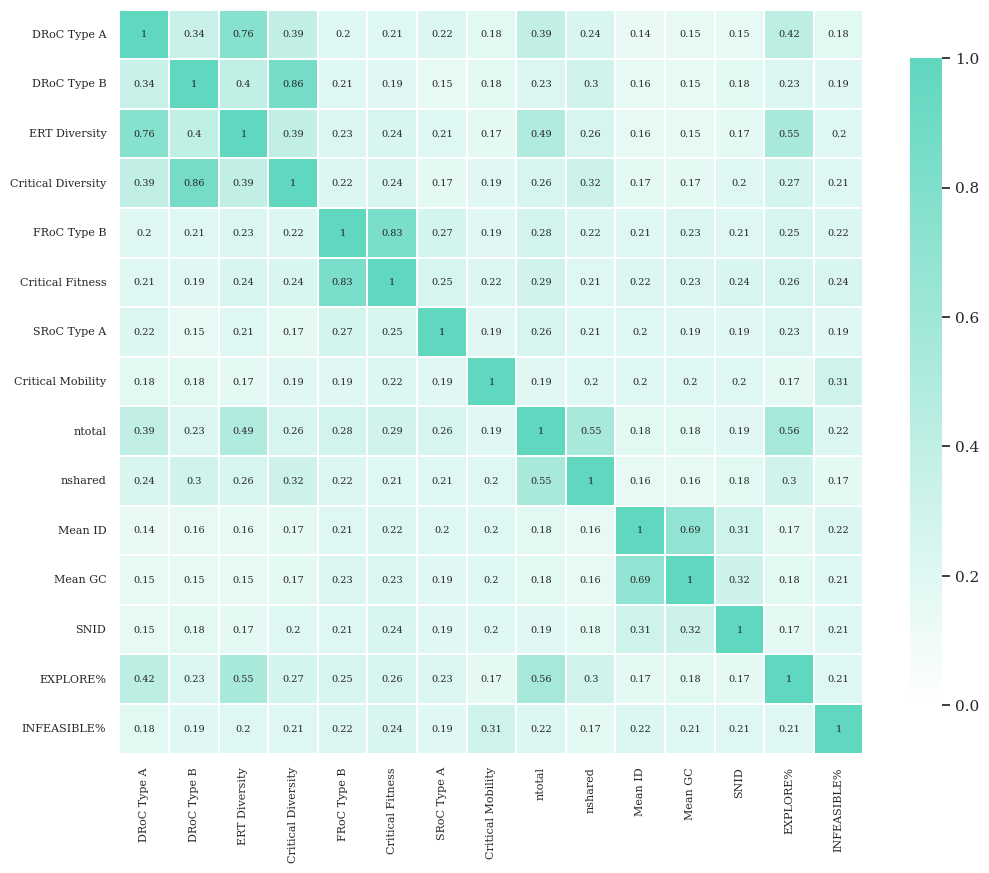

In [52]:
to_drop = ['FRoC Type A', 'ERT Fitness', 'Critical Separation', 'MRoC Type A', 'MRoC Type B', 'SRoC Type B', 'ERT Separation', 'ERT Mobility']
dataset = mean_df.drop(columns=to_drop, inplace=False)
dataset = dataset.drop(index=to_drop, inplace=False)
vmin, cmap = 0, cmap2
plt.figure(figsize=(12,12))
g=sns.heatmap(dataset.round(2), vmin=vmin, vmax=1, cmap=cmap,
              square=True, linewidths=0.1, cbar=True, cbar_kws={'shrink': 0.7},
              annot=True, annot_kws={"fontsize":7}, fmt='.2g',
              xticklabels=1, yticklabels=1) 

g.set_xticklabels(g.get_xticklabels(), fontsize = 8)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
plt.show()
plt.close('all')

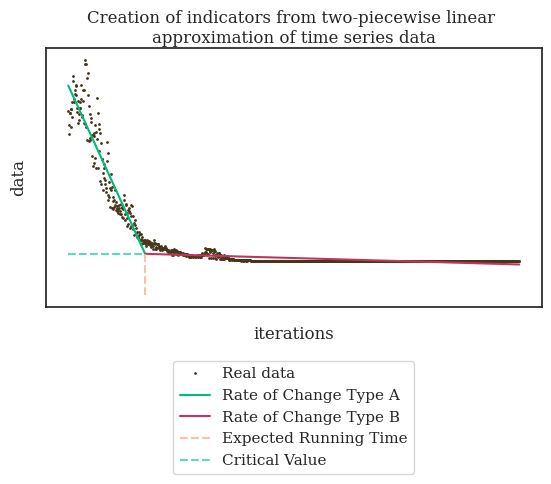

In [90]:
import pwlf

sns.set_theme(style='white')
plt.rcParams["font.family"] = "serif"
# colour order: https://coolors.co/00bb7b-60d7bf-ffbfa0-483519-c0355e
# mint, peach, brown, fuchsia, turquoise
colours = ["#00BB7B", "#FFBFA0", "#483519", "#C0355E", "#60D7BF"]
colour_set = {
    "brown": "#483519",
    "mint": "#00BB7B",
    "peach": "#FFBFA0",
    "fuchsia": "#C0355E",
    "turquoise": "#60D7BF"
}
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colours)

def __knee_point(regression_model: pwlf.PiecewiseLinFit) -> (float, float):
    """
    Calculates the coordinates of the knee point of a two-piecewise linear regression
    :param regression_model: a regression model of the type PiecewiseLinFit of pwlf
    :return: the x- and y-coordinates of the knee point
    """
    knee_point = regression_model.fit(2)
    x = knee_point[1]
    y = (regression_model.predict(x))[0]
    return x, y


div_Df = pd.read_csv("../../processed_results/characteristicTest/10/30/1000/Brown/RingPSO/{c1=0.7; c2=0.7; w=0.9}/1/diversity.csv")
div_Df.replace([np.inf, -np.inf], np.nan, inplace=True)
div_Df.dropna(axis=0, how='any', inplace=True)
y = div_Df['diversity']
x = div_Df['iteration']
y = y + 1

model = pwlf.PiecewiseLinFit(x, y)
kneepoint_x, kneepoint_y = __knee_point(model)

fig = plt.figure()
ax = fig.add_subplot(111)

# real data
ax.plot(x, y, 'o', ms=1, color=colour_set["brown"], label='Real data')

# line 1
x_hat_1 = np.linspace(min(x), kneepoint_x, num=1000)
y_hat_1 = model.predict(x_hat_1)
ax.plot(x_hat_1, y_hat_1, label=f'Rate of Change Type A', color=colour_set["mint"])

# line 2
x_hat_2 = np.linspace(kneepoint_x, max(x), num=1000)  # line_2_end, num=1000)
y_hat_2 = model.predict(x_hat_2)
ax.plot(x_hat_2, y_hat_2, label=f'Rate of Change Type B', color=colour_set["fuchsia"])

# kneepoint
ax.vlines(kneepoint_x, 0.0, kneepoint_y, ls='--', label=f'Expected Running Time',
          color=colour_set["peach"])
ax.hlines(kneepoint_y, 0.0, kneepoint_x, ls='--', label=f'Critical Value',
          color=colour_set["turquoise"])

ax.set(xticklabels=[], yticklabels=[])

# as legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,
                 box.width, box.height * 0.7])

# Put a legend to the bottom of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18))

ax.set_title("Creation of indicators from two-piecewise linear \napproximation of time series data", wrap=True)
ax.set(xlabel="iterations")
ax.set(ylabel='data')

if not os.path.exists(f"../../plots/IndicatorDistinct/"):
    os.makedirs(f"../../plots/IndicatorDistinct/")
plt.savefig(f"../../plots/IndicatorDistinct/linearRegression.pdf", dpi=600, bbox_inches='tight')
plt.show()
plt.close('all')

In [88]:
os.path.exists("../../plots/")

True